# NengoBio Examples

This notebook contains a few examples demonstrating the capabilities of *NengoBio*.

First, we'll need to do a little bit of book-keeping. Feel free to skip ahead to the first example below.

In [1]:
# Set OMP_NUM_THREADS to "1". This has to be done before
# numpy or cvxopt are imported.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import nengo
import nengo_bio as bio
import numpy as np

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

Constants defining the plots below.

In [2]:
PROBE_SYNAPSE = 0.1 # Filter to be used for the network output
T = 10.0 # Total simulation time
T_SKIP = 1.0 # Time to exclude from the RMSE
SEED = 4891 # Network seed
SS = 100 # Plot subsample

`run_and_plot` and `plot_weights` are functions we'll be using to plot the results of a simulation run and to compare them to the desired results.

In [3]:
def run_and_plot(model, probe, expected_fns, plot=True):
    # Run the simulation for the specified time
    with nengo.Simulator(model, progress_bar=None) as sim:
        sim.run(T)

    # Fetch the time and the probe data
    ts = sim.trange()
    expected = np.array([f(ts - PROBE_SYNAPSE) for f in expected_fns]).T
    actual = sim.data[probe]

    # Compute the slice over which to compute the error
    slice_ = slice(int(T_SKIP / sim.dt), int(T / sim.dt))

    # Compute the RMSE and the RMSE
    rms = np.sqrt(np.mean(np.square(expected)))
    rmse = np.sqrt(np.mean(np.square(expected[slice_] - actual[slice_])))

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ts[::SS], expected[::SS], 'k--', label='Expected')
        ax.plot(ts[::SS], actual[::SS], label='Actual')
        ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.3))
        ax.set_title("Normalised RMSE = {:0.2f}%".format(100.0 * rmse / rms))
        ax.set_xlabel("Time $t$ (s)")
        ax.set_ylabel("Decoded value $x$")

    return sim

def plot_weights(sim, conn):
    # Fetch the weights fro the model
    weights = sim.model.params[conn].weights
    WE, WI = weights[bio.Excitatory], weights[bio.Inhibitory]

    # Count the number of empty rows/columns
    def count_zero_rows(X):
        n = 0
        for i in range(X.shape[0]):
            if np.all(X[i] == 0):
                n += 1
        return n
    n_exc_zero_rows, n_inh_zero_rows = count_zero_rows(WE), count_zero_rows(WI)

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].imshow( WE, vmin=0, vmax=np.median(WE[WE > 0]))
    axs[0].set_xlabel('Target neuron index')
    axs[0].set_ylabel('Source neuron index')
    axs[0].set_title('Excitatory ({} rows empty)'.format(n_exc_zero_rows))

    axs[1].imshow(-WI, vmin=0, vmax=np.median(-WI[WI < 0]))
    axs[1].set_xlabel('Target neuron index')
    axs[1].set_ylabel('Source neuron index')
    axs[1].set_title('Inhibitory ({} rows empty)'.format(n_inh_zero_rows))

    axs[2].imshow(WE-WI, vmin=0, vmax=np.median((WE-WI)[(WE-WI) > 0]))
    axs[2].set_xlabel('Target neuron index')
    axs[2].set_ylabel('Source neuron index')
    axs[2].set_title('Combined weights')

    fig.tight_layout()

## Example 1: Communication Channel

### Multiple pre-ensembles

This first example demonstrates the ability of *NengoBio* to support multiple pre-objects in `bio.connection`. When passing a `tuple` (using "()" notation) to the connection object, the dimensions of the pre-objects are stacked.

Here, we're connecting two one-dimensional pre-ensembles to a two-dimensional post-ensemble.

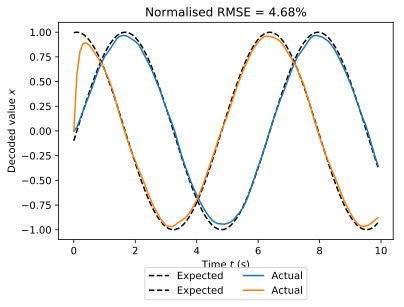

In [4]:
f1, f2 = lambda t: np.sin(t), lambda t: np.cos(t)
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(f1)
    inp_b = nengo.Node(f2)

    ens_a = bio.Ensemble(n_neurons=101, dimensions=1)
    ens_b = bio.Ensemble(n_neurons=102, dimensions=1)
    ens_c = bio.Ensemble(n_neurons=103, dimensions=2)

    nengo.Connection(inp_a, ens_a)
    nengo.Connection(inp_b, ens_b)

    bio.Connection((ens_a, ens_b), ens_c)

    probe = nengo.Probe(ens_c, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (f1, f2));

### Marking neurons as excitatory/inhibitory

The `p_exc` and `p_inh` arguments on the `bio.Ensemble` object can be used to mark a certain fraction of the neurons in the ensemble as excitatory/inhibitory.

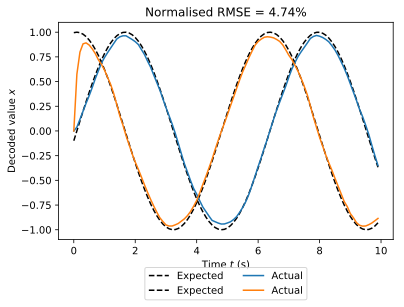

In [5]:
f1, f2 = lambda t: np.sin(t), lambda t: np.cos(t)
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(f1)
    inp_b = nengo.Node(f2)

    ens_a = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=0.8)
    ens_b = bio.Ensemble(n_neurons=102, dimensions=1, p_exc=0.8)
    ens_c = bio.Ensemble(n_neurons=103, dimensions=2)

    nengo.Connection(inp_a, ens_a)
    nengo.Connection(inp_b, ens_b)

    bio.Connection((ens_a, ens_b), ens_c)

    probe = nengo.Probe(ens_c, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (f1, f2));

## Example 2: Parisien Transform (Dale's Principle with inhibitory interneurons)

### Basic circuit ‒ defining inhibitory interneurons

Inhibition in biological systems is often mediated via inhibitory interneurons. This example attempts to builds such a circuit by projecting from both the excitatory pre-population and a set of inhibitory interneurons onto the same target population.

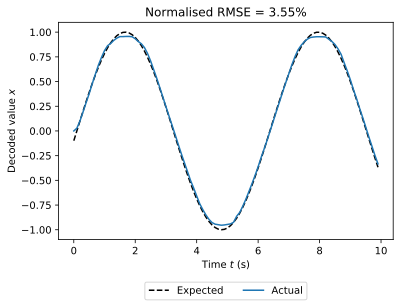

In [6]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection((ens_source, ens_inhint), ens_target,
                   function=lambda x: np.mean(x))

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t),));

This seems to work quite well!

### Defining evaluation points to compute functions of shared dimensions

Let's see what happens if we try to compute some function, for example $f(x) = x^2$.

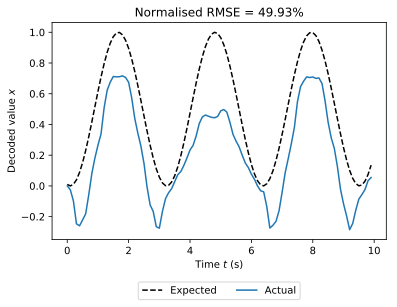

In [7]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))
    
    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection((ens_source, ens_inhint), ens_target,
                   function=lambda x: np.mean(x) ** 2)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

This doesn't look very good. The issue is that we're optimizing over a 2D space, i.e., the Cartesian product of all possible represented values of the pre-population and the interneuron population. However, the pre-population and the interneuron population should always represent the same value.

Let's see what happens when we set the evaluation points of the connection to the diagonal:

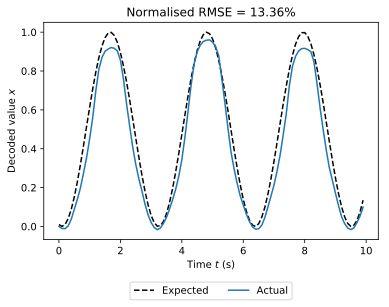

In [8]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))
    
    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection((ens_source, ens_inhint), ens_target,
                   function=lambda x: np.mean(x) ** 2,
                   eval_points=([1, 1] * np.linspace(-1, 1, 750)[:, None]),
                   scale_eval_points=False)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

This looks much nicer.

### The NengoBio `set` notation for shared dimensions

There is a special syntax that tells *NengoBio* that two pre-populations represent the same value. Instead of the tuple notation we use the `set` notation (i.e., "{}") to specify the pre-populations.

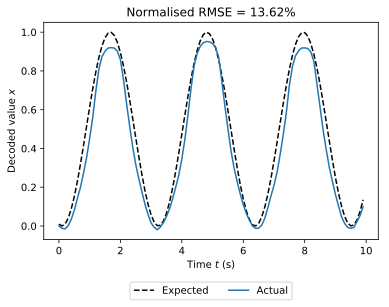

In [9]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))
    
    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection({ens_source, ens_inhint}, ens_target,
                   function=lambda x: x ** 2)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

Note that the error in the second example is a little higher due to the samples not being equally distributed across the space. Specifying the evaluation points explicitly will give exactly the same results as above:

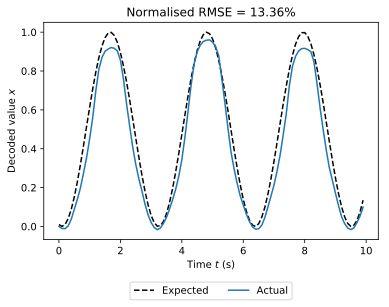

In [10]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection({ens_source, ens_inhint}, ens_target,
                   function=lambda x: x ** 2,
                   eval_points=np.linspace(-1, 1, 750).reshape(-1, 1),
                   scale_eval_points=False)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

### Subthreshold relaxation

One issue with the default weight solver is that the solver treats negative post-synaptic currents the same way as positive post-synaptic currents. In other words, the solver tries to find weights that *exactly* produce negative target currents. However, and at least for most simple neuron models, all currents below a certain threshold result in a zero spike rate. Thus, the exact magnitute of these subthreshold currents does not matter.

We can *relax* the optimization problem by instructing the optimizer to focus on the relevant parts of the optimization problem. We do this by passing the `relax=True` flag to the solver.

**Note:** Setting `relax=True` significantly increases the time it takes to solve for weights. This is because the relaxed optimization problem can no longer  be expressed as a NNLS (non-negative least squares) problem, a special case of a QP (quadratic program).

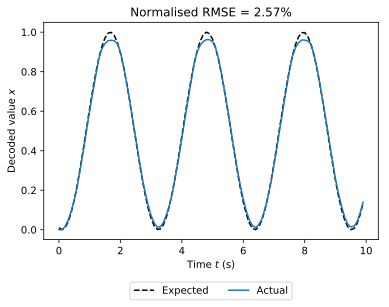

In [11]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint,
                   solver=bio.solvers.QPSolver(relax=True))
    bio.Connection({ens_source, ens_inhint}, ens_target,
                   function=lambda x: x ** 2,
                   solver=bio.solvers.QPSolver(relax=True))

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

Well, setting `relax=True` improves the overall performance quite significantly!

## Example 3: Sparse connection matrices

Sometimes we have pretty good data about the number of post-synapses. *NengoBio* allows to specifiy the number of post-synapses on a per-connection basis using the `max_n_post_synapses`, `max_n_post_synapses_exc` and `max_n_post_synapses_inh` parameters.

Per default, the weight matrices are fairly dense, as can be seen in the combined exitatory/inhibitory weight matrix below.

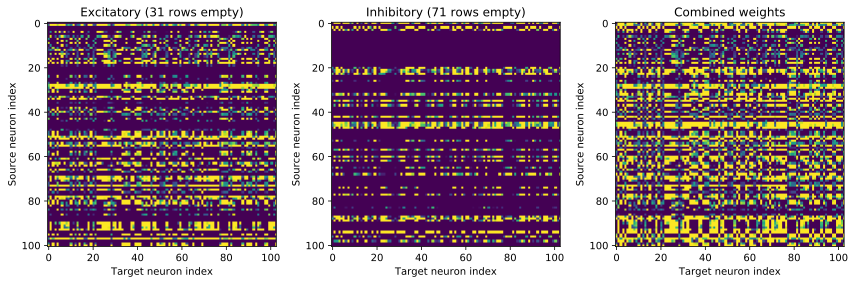

In [12]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=0.8)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    conn = bio.Connection(ens_source, ens_target)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

sim = run_and_plot(model, probe, (lambda t: np.sin(t),), plot=False)
plot_weights(sim, conn)

With the afforementioned attributes we can force a sparse weight matrix. Setting the `max_n_post_synapses` attribute cases up to `max_n_post_synapses` synapses to be randomly selected, independent of the synapse type.

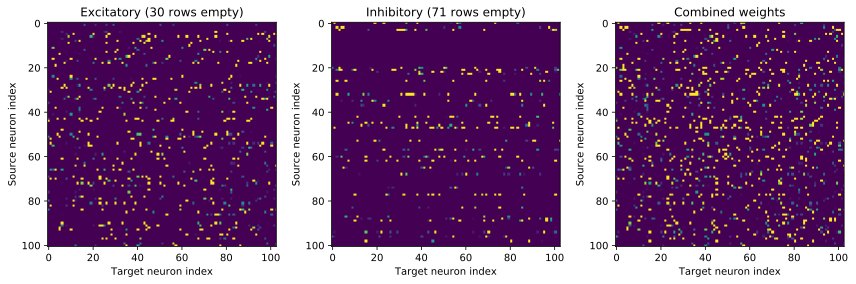

In [13]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=0.8)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    conn = bio.Connection(ens_source, ens_target,
                          max_n_post_synapses=20)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

sim = run_and_plot(model, probe, (lambda t: np.sin(t),), plot=False)
plot_weights(sim, conn)

Conversely, setting `max_n_post_synapses_exc` or `max_n_post_synapses_inh` (or both, or one of them in conjunction with `max_n_post_synapses`) specifies the exact number of synapses per type.

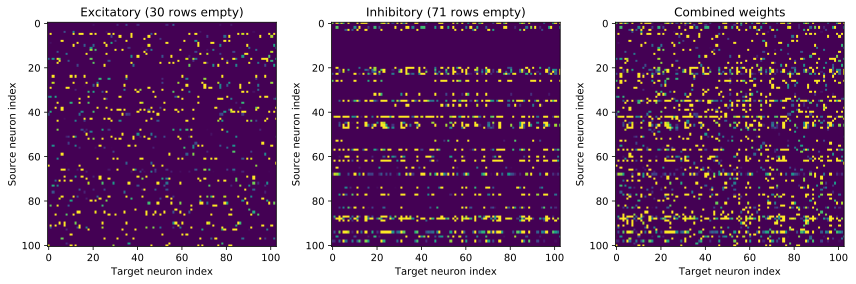

In [14]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=0.8)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    conn = bio.Connection(ens_source, ens_target,
                          max_n_post_synapses_exc=10)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

sim = run_and_plot(model, probe, (lambda t: np.sin(t),), plot=False)
plot_weights(sim, conn)